# Goldenspike, an example of an end-to-end analysis using RAIL

author: Sam Schmidt, Eric Charles, Alex Malz, John Franklin Crenshaw, others...<br>
last run successfully: August 14, 2022

This notebook demonstrates how to use a the various RAIL Modules to draw synthetic samples of fluxes by color, apply physical effects to them, train photo-Z estimators on the samples, test and validate the preformance of those estimators, and to use the RAIL summarization modules to obtain n(z) estimates based on the p(z) estimates.

### Creation 

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the create Engine.  This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will draw both test and training samples from a RAIL Engine object. Then we will demonstrate how to use RAIL degraders to apply effects to those samples.

### Training and Estimation

The RAIL Informer modules "train" or "inform" models used to estimate p(z) given band fluxes (and potentially other information).

The RAIL Estimation modules then use those same models to actually apply the model and extract the p(z) estimates.

### p(z) Validation 

The RAIL Validator module applies various metrics 

### p(z) to n(z) Summarization

The RAIL Summarization modules convert per-galaxy p(z) posteriors to ensemble n(z) estimates. 

###  Imports

In [1]:
# Prerquisites, os, numpy, pathlib, pzflow, tables_io
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io

In [2]:
# Various rail modules
import rail
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, QuantityCut
from rail.creation.engines.flowCreator import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.bpz_lite import BPZ_lite
from rail.estimation.algos.knnpz import Inform_KNearNeighPDF, KNearNeighPDF
from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.estimation.algos.naiveStack import NaiveStack
from rail.estimation.algos.pointEstimateHist import PointEstimateHist

from rail.evaluation.evaluator import Evaluator

RAIL now uses ceci as a back-end, which takes care of a lot of file I/O decisions to be consistent with other choices in DESC.

This bit effectively overrides a ceci default to prevent overwriting previous results, generally good but not necessary for this demo.

The `DataStore` uses `DataHandle` objects to keep track of the connections between the various stages.  When one stage returns a `DataHandle` and then you pass that `DataHandle` to another stage, the underlying code can establish the connections needed to build a reproducilble pipeline.   

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

The path stuff for setup establishes where to find a pre-trained creator's file.
TODO: make an issue for trainign one through RAIL rather than externally with pzflow.

Here we need a few configuration parameters to deal with differences in data schema between existing PZ codes.

In [4]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

## Train the Flow Creator

First we need to train the normalizing flow that will serve as the creator for this notebook.

In the cell below, we load the example galaxy catalog from PZFlow, and save it so that it can be used to train the flow. We also set the path where we will save the flow.

In [5]:
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"
catalog = get_galaxy_data().rename(band_dict, axis=1)
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

flow_file = DATA_DIR / "trained_flow.pkl"

In [6]:
flow_modeler_params = {
    "name": "flow_modeler",
    "base": catalog_file,
    "model": flow_file,
    "flow_seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {},
}

In [7]:
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)

2022-08-14 09:04:42,975 ipykernel_launcher.py absl[129577] DEBUG Initializing backend 'interpreter'
2022-08-14 09:04:42,980 ipykernel_launcher.py absl[129577] DEBUG Backend 'interpreter' initialized
2022-08-14 09:04:42,980 ipykernel_launcher.py absl[129577] DEBUG Initializing backend 'cpu'
2022-08-14 09:04:42,988 ipykernel_launcher.py absl[129577] DEBUG Backend 'cpu' initialized
2022-08-14 09:04:42,988 ipykernel_launcher.py absl[129577] DEBUG Initializing backend 'tpu_driver'
2022-08-14 09:04:42,989 ipykernel_launcher.py absl[129577] INFO Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-08-14 09:04:42,989 ipykernel_launcher.py absl[129577] DEBUG Initializing backend 'cuda'
2022-08-14 09:04:43.003488: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-08-14 09:04:43.003610: E e

In [8]:
flow = flow_modeler.fit_model()

2022-08-14 09:04:45,857 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.00023436546325683594 sec
2022-08-14 09:04:45,858 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192516165200 for args (ShapedArray(float32[]),).
2022-08-14 09:04:45,871 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.010399103164672852 sec
2022-08-14 09:04:45,873 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0002684593200683594 sec
2022-08-14 09:04:45,874 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192516140384 for args (ShapedArray(float32[]),).
2022-08-14 09:04:45,883 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.007188558578491211 sec
2022-08-14 09:04:45,885 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.00027561187744140625 sec
2022-08-14 09:04:45

Inserting handle into data store.  base: /phys/users/jfc20/RAIL/examples/goldenspike/data/base_catalog.pq, flow_modeler
Training 30 epochs 
Loss:


2022-08-14 09:04:46,479 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming loss_fn for jit in 0.5241782665252686 sec
2022-08-14 09:04:46,485 ipykernel_launcher.py absl[129577] DEBUG Compiling loss_fn (140192497379744) for 44 args.
2022-08-14 09:04:50,011 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of loss_fn in 2.56254243850708 sec
2022-08-14 09:04:50,363 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming _threefry_split for jit in 0.0020198822021484375 sec
2022-08-14 09:04:50,364 ipykernel_launcher.py absl[129577] DEBUG Compiling _threefry_split (140192392503600 for args (ShapedArray(uint32[2]),).
2022-08-14 09:04:50,426 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of _threefry_split in 0.04003596305847168 sec
2022-08-14 09:04:50,429 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming _unstack for jit in 0.0007472038269042969 sec
2022-08-14 09:04:50,429 ipykernel_launcher.py abs

(0) 19.6684


2022-08-14 09:04:50,681 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of _shuffle in 0.1570734977722168 sec
2022-08-14 09:04:50,730 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0002493858337402344 sec
2022-08-14 09:04:50,731 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0001857280731201172 sec
2022-08-14 09:04:50,732 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192515446640 for args (ShapedArray(float32[]),).
2022-08-14 09:04:50,747 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.011523723602294922 sec
2022-08-14 09:04:52,166 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming step for jit in 1.4166481494903564 sec
2022-08-14 09:04:52,178 ipykernel_launcher.py absl[129577] DEBUG Compiling step (140192392504960) for 129 args.
2022-08-14 09:05:11,246 ipykernel_launcher.py absl[129577] DEBU

(1) 4.1308
(2) 3.3642
(3) 1.1700
(4) 0.9479
(5) -0.1061
(6) 0.6083
(7) -1.0593
(8) 0.6644
(9) -1.5443
(10) -0.6973
(11) -1.9570
(12) -1.8115
(13) -2.0670
(14) -1.8258
(15) -1.1367
(16) -2.0918
(17) -0.3467
(18) -1.0141
(19) -2.6147
(20) -2.5145
(21) -1.9062
(22) -1.2444
(23) -1.4500
(24) -3.0384
(25) -2.3309
(26) -3.2411
(27) -3.3246
(28) -3.1920
(29) -2.3894
(30) -2.4082
Inserting handle into data store.  model_flow_modeler: /phys/users/jfc20/RAIL/examples/goldenspike/data/inprogress_trained_flow.pkl, flow_modeler


## Make mock data

First, we make the stages.
Note that training and test data will refer to the same flow file for the Engine, but they otherwise have different stages.

For both the training and test data we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to smear the data
3. Use the ColumnMapper to rename some of the columns, as needed by FlowPosterior module
4. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

### Training sample

For the training data we are going to apply a couple of extra degradation effects to the data beyond what we do to create test data, as the training data will have some spectroscopic incompleteness.  This will allow us to see how the trained models perform with imperfect training data.

More details about the degraders are available in the `rail/examples/creation/degradation_demo.ipynb` notebook.


In [9]:
flow_creator_train = FlowCreator.make_stage(
    name='flow_creator_train', 
    flow=flow_file, 
    n_samples=50,
    seed=1235,
)

lsst_error_model_train = LSSTErrorModel.make_stage(
    name='lsst_error_model_train',
    bandNames=band_dict, 
    seed=29,
)

inv_redshift = InvRedshiftIncompleteness.make_stage(
    name='inv_redshift',
    pivot_redshift=1.0,
)

line_confusion = LineConfusion.make_stage(
    name='line_confusion', 
    true_wavelen=5007.,
    wrong_wavelen=3727.,
    frac_wrong=0.05,
)

quantity_cut = QuantityCut.make_stage(
    name='quantity_cut',    
    cuts={'mag_i_lsst': 25.0},
)

col_remapper_train = ColumnMapper.make_stage(
    name='col_remapper_train', 
    columns=rename_dict,
)
   
table_conv_train = TableConverter.make_stage(
    name='table_conv_train', 
    output_format='numpyDict',
)

2022-08-14 09:06:54,814 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming atleast_1d for jit in 0.00040841102600097656 sec


Inserting handle into data store.  flow: /phys/users/jfc20/RAIL/examples/goldenspike/data/trained_flow.pkl, flow_creator_train


In [10]:
train_data_orig = flow_creator_train.sample(150, 1235)
train_data_errs = lsst_error_model_train(train_data_orig, seed=66)
train_data_inc = inv_redshift(train_data_errs)
train_data_conf = line_confusion(train_data_inc)
train_data_cut = quantity_cut(train_data_conf)
train_data_pq = col_remapper_train(train_data_cut)
train_data = table_conv_train(train_data_pq)

2022-08-14 09:06:55,963 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0004420280456542969 sec
2022-08-14 09:06:55,964 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192023956352 for args (ShapedArray(float32[]),).
2022-08-14 09:06:55,982 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.011608600616455078 sec
2022-08-14 09:06:55,991 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming _uniform for jit in 0.006634712219238281 sec
2022-08-14 09:06:55,992 ipykernel_launcher.py absl[129577] DEBUG Compiling _uniform (140192515423104 for args (ShapedArray(uint32[2]), ShapedArray(int32[], weak_type=True), ShapedArray(int32[], weak_type=True)).
2022-08-14 09:06:56,105 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of _uniform in 0.07826757431030273 sec
2022-08-14 09:06:56,107 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming pr

Inserting handle into data store.  output_flow_creator_train: inprogress_output_flow_creator_train.pq, flow_creator_train
Inserting handle into data store.  output_lsst_error_model_train: inprogress_output_lsst_error_model_train.pq, lsst_error_model_train
Inserting handle into data store.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift
Inserting handle into data store.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


Let's examine the quantities that we've generated, we'll use the handy `tables_io` package to temporarily write to a pandas dataframe for quick writeout of the columns:

In [11]:
train_table = tables_io.convertObj(train_data.data, tables_io.types.PD_DATAFRAME)
train_table.head()

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.929139,26.386290,0.264202,26.011219,0.064981,25.400499,0.037162,24.774897,0.031654,24.439359,0.041422,24.482758,0.097952
1,0.729459,26.275788,0.241332,25.964869,0.062369,25.085100,0.028151,24.257431,0.020211,24.023317,0.028700,23.936744,0.060490
2,0.150781,25.088871,0.087562,24.417219,0.016278,24.179256,0.013204,24.045854,0.016929,24.040113,0.029125,23.934374,0.060363
3,0.207901,21.273199,0.006012,19.499489,0.005013,18.716470,0.005004,18.276261,0.005004,18.151735,0.005007,18.094287,0.005020
4,1.004017,26.935462,0.408185,26.526229,0.102269,25.924684,0.059166,24.994597,0.038431,24.279500,0.035957,23.877355,0.057386


You see that we've generated redshifts, ugrizy magnitudes, and magnitude errors with names that match those in the cosmoDC2_v1.1.4_image data.

### Testing sample

For the test sample we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to smear the data
3. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
4. Use ColumnMapper to rename some of the columns to match DC2
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

In [13]:
flow_creator_test = FlowCreator.make_stage(
    name='flow_creator_test', 
    flow=flow_file, 
    n_samples=50,
)
      
lsst_error_model_test = LSSTErrorModel.make_stage(
    name='lsst_error_model_test',
    bandNames=band_dict,
)
                
col_remapper_test = ColumnMapper.make_stage(
    name='col_remapper_test', 
    hdf5_groupname='',
    columns=rename_dict,
)

flow_post_test = FlowPosterior.make_stage(
    name='flow_post_test',
    column='redshift',
    flow=flow_file,
    grid=np.linspace(0., 5., 21),
)

table_conv_test = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict')


In [34]:
test_data_orig = flow_creator_test.sample(150, 1234)
test_data_errs = lsst_error_model_test(test_data_orig,seed=58)
test_data_post = flow_post_test.get_posterior(test_data_errs, 'redshift', err_samples=None)
test_data_pq = col_remapper_test(test_data_errs)
test_data = table_conv_test(test_data_pq)

2022-08-14 09:17:38,088 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0003802776336669922 sec
2022-08-14 09:17:38,089 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140188404119968 for args (ShapedArray(float32[]),).
2022-08-14 09:17:38,108 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.014259576797485352 sec
2022-08-14 09:17:38,111 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0003933906555175781 sec
2022-08-14 09:17:38,112 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140188404120288 for args (ShapedArray(float32[]),).
2022-08-14 09:17:38,129 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.012842416763305664 sec
2022-08-14 09:17:38,133 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.0003516674041748047 sec
2022-08-14 09:17:38,1

Inserting handle into data store.  output_flow_creator_test: inprogress_output_flow_creator_test.pq, flow_creator_test
Inserting handle into data store.  output_lsst_error_model_test: inprogress_output_lsst_error_model_test.pq, lsst_error_model_test


2022-08-14 09:17:38,267 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of reshape in 0.0057141780853271484 sec
2022-08-14 09:17:38,269 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.00025272369384765625 sec
2022-08-14 09:17:38,269 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192024261632 for args (ShapedArray(float32[2709]),).
2022-08-14 09:17:38,278 ipykernel_launcher.py absl[129577] DEBUG Finished XLA compilation of broadcast_in_dim in 0.00553131103515625 sec
2022-08-14 09:17:38,279 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.00024962425231933594 sec
2022-08-14 09:17:38,280 ipykernel_launcher.py absl[129577] DEBUG Finished tracing + transforming prim_fun for jit in 0.00016617774963378906 sec
2022-08-14 09:17:38,281 ipykernel_launcher.py absl[129577] DEBUG Compiling prim_fun (140192393072448 for args (ShapedArray(float32[129,6]),).
2022-08-14 09:17:3

Inserting handle into data store.  output_flow_post_test: inprogress_output_flow_post_test.hdf5, flow_post_test
Warning.  Failed to convert column 'DeviceArray' object has no attribute 'data'
Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [15]:
test_table = tables_io.convertObj(test_data.data, tables_io.types.PD_DATAFRAME)
test_table.head()

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,1.742564,26.885539,0.392811,26.471743,0.097505,26.379589,0.088466,26.068843,0.099434,25.696648,0.125543,25.357042,0.207658
1,0.070060,23.768243,0.027594,22.934557,0.006522,22.476556,0.005686,22.292358,0.006039,22.129775,0.007186,21.987226,0.011549
2,0.430297,NaN,NaN,27.949943,0.338150,26.971789,0.148141,26.616083,0.159762,26.633655,0.276565,26.090324,0.376013
3,2.063962,27.346028,0.554047,27.424207,0.220596,27.042942,0.157459,26.958964,0.213477,26.366997,0.222106,28.059359,1.371483
4,0.630674,NaN,NaN,27.279026,0.195362,26.712515,0.118391,25.816130,0.079614,25.477869,0.103759,25.282335,0.195035


## "Inform" some estimators

More details about the process of "informing" or "training" the models used by the estimators is available in the `rail/examples/estimation/RAIL_estimation_demo.ipynb` notebook.

We use "inform" rather than "train" to generically refer to the preprocessing of any prior information.
For a machine learning estimator, that prior information is a training set, but it can also be an SED template library for a template-fitting or hybrid estimator.

In [36]:
inform_knn = Inform_KNearNeighPDF.make_stage(
    name='inform_knn', 
    input='inprogress_output_table_conv_train.hdf5', 
    nondetect_val=np.nan,
    model='knnpz.pkl', 
    hdf5_groupname='',
)

inform_fzboost = Inform_FZBoost.make_stage(
    name='inform_FZBoost', 
    input='inprogress_output_table_conv_train.pq',                                      
    model='fzboost.pkl', 
    hdf5_groupname='',
)

In [37]:
inform_knn.inform(train_data)
inform_fzboost.inform(train_data)

/phys/users/jfc20/RAIL/rail/estimation/algos/knnpz.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knndf.loc[np.isnan(knndf[col]), col] = self.config.mag_limits[col]


split into 51 training and 17 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model_inform_knn: inprogress_knnpz.pkl, inform_knn
stacking some data...
read in training data
fit the model...
[09:21:29] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:21:30] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




## Estimate photo-z posteriors

More details about the estimators is available in the `rail/examples/estimation/RAIL_estimation_demo.ipynb` notebook.

`randomPZ` is a very simple class that does not actually predict a meaningful photo-z, instead it produces a randomly drawn Gaussian for each galaxy.<br>
`trainZ` is our "pathological" estimator, it makes a PDF from a histogram of the training data and assigns that PDF to every galaxy.<br>
`BPZ_lite` is a template-based code that outputs the posterior estimated given a specific template set and Bayesian prior. See Benitez (2000) for more details.<br>


In [66]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file='../estimation/configs/test_bpz.columns',
)

estimate_knn = KNearNeighPDF.make_stage(
    name='estimate_knn', 
    hdf5_groupname='', 
    nondetect_val=np.nan, 
    model=inform_knn.get_handle('model'),
)

estimate_fzboost = FZBoost.make_stage(
    name='test_FZBoost', 
    nondetect_val=np.nan,
    model=inform_fzboost.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', 
    output='fzboost_estim'),
)

In [67]:
knn_estimated = estimate_knn.estimate(test_data)
fzboost_estimated = estimate_fzboost.estimate(test_data)
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Inserting handle into data store.  output_estimate_knn: inprogress_output_estimate_knn.hdf5, estimate_knn
Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Inserting handle into data store.  output_test_FZBoost: inprogress_output_test_FZBoost.hdf5, test_FZBoost
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


## Evaluate the estimates

Now we evaluate metrics on the estimates, separately for each estimator.  

Each call to the `Evaluator.evaluate` will create a table with the various performance metrics. 
We will store all of these tables in a dictionary, keyed by the name of the estimator.

In [68]:
eval_dict = dict(bpz=bpz_estimated, fzboost=fzboost_estimated, knn=knn_estimated)
truth = test_data_orig

result_dict = {}
for key, val in eval_dict.items():
    the_eval = Evaluator.make_stage(name=f'{key}_eval', truth=truth)
    result_dict[key] = the_eval.evaluate(val, truth)

/phys/users/jfc20/RAIL/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Inserting handle into data store.  output_fzboost_eval: inprogress_output_fzboost_eval.hdf5,

The Pandas DataFrame output format conveniently makes human-readable printouts of the metrics.  
This next cell will convert everything to Pandas.

In [69]:
import tables_io
results_tables = {key:tables_io.convertObj(val.data, tables_io.types.PD_DATAFRAME) for key,val in result_dict.items()}

In [70]:
results_tables['knn']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.278046,9.574418e-11,3.642103,1.947877e-09,0.367799,0.343829,-0.012583,0.013333,0.351708,0.683943,NaN


In [71]:
results_tables['fzboost']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.381645,3.731436e-20,6.791493,1.060240e-10,0.656885,0.409317,-0.0083,0.026667,0.4147,5.506814,NaN


In [72]:
results_tables['bpz']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.319188,4.310643e-14,4.568928,1.851030e-11,0.495898,0.40901,-0.004523,0.026667,0.367411,10.579162,NaN


## Summarize the per-galaxy redshift constraints to make population-level distributions

{introduce the summarizers}

First we make the stages, then execute them, then plot the output.

In [73]:
point_estimate_test = PointEstimateHist.make_stage(name='point_estimate_test')
naive_stack_test = NaiveStack.make_stage(name='naive_stack_test')

In [74]:
point_estimate_ens = point_estimate_test.summarize(eval_dict['bpz'])
naive_stack_ens = naive_stack_test.summarize(eval_dict['bpz'])

Inserting handle into data store.  output_point_estimate_test: inprogress_output_point_estimate_test.hdf5, point_estimate_test
Inserting handle into data store.  output_naive_stack_test: inprogress_output_naive_stack_test.hdf5, naive_stack_test


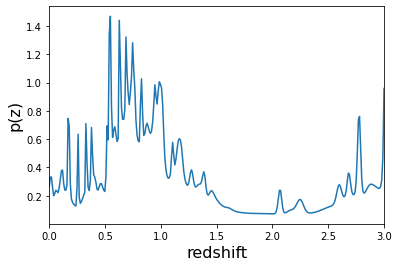

In [75]:
_ = naive_stack_ens.data.plot_native(xlim=(0,3))

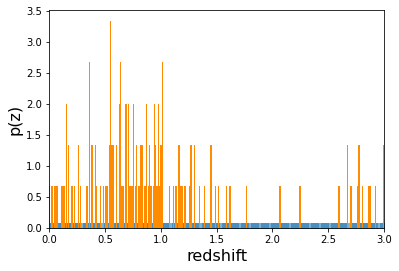

In [76]:
_ = point_estimate_ens.data.plot_native(xlim=(0,3))

### Convert this to a `ceci` Pipeline

Now that we have all these stages defined and configured, and that we have established the connections between them by passing `DataHandle` objects between them, we can build a `ceci` Pipeline.


In [77]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [
    # train the flow
    flow_modeler,
    # create the training catalog
    flow_creator_train, lsst_error_model_train, inv_redshift,
    line_confusion, quantity_cut, col_remapper_train, table_conv_train,
    # create the test catalog
    flow_creator_test, lsst_error_model_test, col_remapper_test, table_conv_test,
    # inform the estimators
    inform_knn, inform_fzboost,
    # estimate posteriors
    estimate_knn, estimate_fzboost, estimate_bpz,
    # estimate n(z), aka "summarize"
    point_estimate_test, naive_stack_test,
]
for stage in stages:
    pipe.add_stage(stage)

In [78]:
pipe.initialize(dict(base=catalog_file, flow=flow_file), dict(output_dir='.', log_dir='.', resume=False), None)

ValueError: 
Some required inputs to the pipeline could not be found,
(or possibly your pipeline is cyclic):

Stage estimate_bpz is missing input(s): model
Stage point_estimate_test is missing input(s): output_estimate_bpz
Stage naive_stack_test is missing input(s): output_estimate_bpz


In [ ]:
pipe.save('tmp_goldenspike.yml')

### Read back the pipeline and run it

In [ ]:
pr = ceci.Pipeline.read('tmp_goldenspike.yml')

In [ ]:
pr.run()

# Clean up:

Finally, you'll notice that we've written a large number of temporary files in the course of running this demo, to delete these and clean up the directory just run the `cleanup.sh` script in this directory to delete the data files.